# прогнозирование поле нефтенасыщенности в зонах высокой неопределенности

внутри этого ноутбука собраны все этапы от чтения сырых данных до тренировки диффузионной модели.

## подготовка окружения

In [1]:
from __future__ import annotations

import os
import math
from datetime import datetime
from pathlib import Path
from typing import Iterable, Tuple

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Dataset

# устанавливаем utf-8 на уровне процесса
os.environ["PYTHONIOENCODING"] = "utf-8"


## подготовка данных и наборов

здесь описаны функции для преобразования petrel (spe9) и tnavigator, генерации карт насыщенности и формирования pytorch-датасета.

In [2]:
# блок обработки данных и наборов

GDM_LAYERS = 50
GDM_HEIGHT = 50
GDM_WIDTH = 50
GDM_TOTAL_CELLS = GDM_LAYERS * GDM_HEIGHT * GDM_WIDTH
GDM_STATIC_FIELDS = [
    ("dx", "DX"),
    ("dy", "DY"),
    ("dz", "DZ"),
    ("permx", "INIT_PERMX"),
    ("permy", "INIT_PERMY"),
    ("permz", "INIT_PERMZ"),
    ("poro", "INIT_PORO"),
]


def _read_lines(path: Path) -> list[str]:
    """читаем файл и нормализуем null байты из spe9."""
    text = path.read_bytes().decode("latin-1")
    return [line for line in text.replace("\x00", "").splitlines()]


def parse_dimensions(path: Path) -> Tuple[int, int, int]:
    """находим параметры сетки (i, j, k) по ключевому слову dimens."""
    lines = _read_lines(path)
    for idx, line in enumerate(lines):
        token = line.strip()
        if token.startswith("DIMENS"):
            for next_line in lines[idx + 1 :]:
                next_token = next_line.strip()
                if not next_token or next_token.startswith("--"):
                    continue
                numbers = next_token.replace("/", "").split()
                if len(numbers) >= 3:
                    return tuple(int(tok) for tok in numbers[:3])
    raise ValueError("Could not parse DIMENS from SPE9 file.")


def parse_perm_values(path: Path, dims: Tuple[int, int, int]) -> np.ndarray:
    """разбираем блок permx и возвращаем проницаемости (k, j, i)."""
    lines = _read_lines(path)
    i_dim, j_dim, k_dim = dims
    values: list[float] = []
    in_perm = False
    for line in lines:
        token = line.strip()
        if not token:
            continue
        if token.startswith("PERMX"):
            in_perm = True
            continue
        if "PERMY" in token:
            break
        if not in_perm:
            continue
        if token.startswith("--") or token.startswith("LAYER") or token.startswith("ROW"):
            continue
        values.extend(
            float(val)
            for val in token.split()
            if val not in {"/", ""}
        )
        if len(values) >= i_dim * j_dim * k_dim:
            break
    expected = i_dim * j_dim * k_dim
    if len(values) < expected:
        raise ValueError(
            f"PERMX data contains only {len(values)} entries, expected {expected}."
        )
    arr = np.array(values[:expected], dtype=np.float32)
    perm = arr.reshape(k_dim, j_dim, i_dim)
    return perm


def parse_porosity(path: Path) -> np.ndarray:
    """считываем блок poro с одним значением на слой."""
    lines = _read_lines(path)
    poros = []
    in_poro = False
    for line in lines:
        token = line.strip()
        if not token:
            continue
        if token.startswith("PORO"):
            in_poro = True
            continue
        if in_poro:
            if token.startswith("--"):
                continue
            entries = token.split()
            for entry in entries:
                if entry == "/":
                    return np.array(poros, dtype=np.float32)
                if "*" in entry:
                    _, value = entry.split("*", 1)
                    poros.append(float(value))
                else:
                    try:
                        poros.append(float(entry))
                    except ValueError:
                        continue
    return np.array(poros, dtype=np.float32)


def parse_injector_location(path: Path) -> Tuple[int, int]:
    """находим координаты инжектора (i, j) в комвдате."""
    lines = _read_lines(path)
    in_compdat = False
    for line in lines:
        token = line.strip()
        if token.startswith("COMPDAT"):
            in_compdat = True
            continue
        if not in_compdat:
            continue
        if not token or token.startswith("--"):
            continue
        parts = token.replace("'", "").split()
        if parts and parts[0].startswith("INJE"):
            i = int(parts[1]) - 1
            j = int(parts[2]) - 1
            return i, j
    raise ValueError("Injector not found in COMPDAT.")


def generate_saturation_series(
    perm: np.ndarray,
    porosity: np.ndarray,
    injector: Tuple[int, int],
    times: Iterable[float],
    rng: np.random.Generator | None = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """генерируем карты насыщенности по геометрии spe9."""
    if rng is None:
        rng = np.random.default_rng(42)

    layers, rows, cols = perm.shape
    if porosity.shape[0] != layers:
        raise ValueError("Porosity vector length must match number of layers.")

    # нормализуем perm к диапазону [0, 1]
    perm_norm = (perm - perm.min()) / (perm.max() - perm.min() + 1e-8)
    ii, jj = np.meshgrid(np.arange(cols), np.arange(rows), indexing="xy")
    inj_i, inj_j = injector
    distance = np.sqrt((ii - inj_i) ** 2 + (jj - inj_j) ** 2)
    max_dist = float(distance.max())
    if max_dist <= 0:
        max_dist = 1.0
    distance_norm = distance / max_dist

    layer_bias = 1.0 - 0.3 * (np.arange(layers) / max(1, layers - 1))
    layer_bias = layer_bias[:, None, None]

    times_array = np.array(list(times), dtype=np.float32)
    sat = np.zeros((len(times_array), layers, rows, cols), dtype=np.float32)
    tau_base = 0.2

    for idx, t in enumerate(times_array):
        front = t * max_dist * 1.2
        sigma = max_dist * 0.08 + 1e-6
        progress = 0.5 * (np.tanh((front - distance) / sigma) + 1.0)
        progress = np.clip(progress, 0.0, 1.0)
        tau = tau_base * (1.0 + distance_norm)[None, ...] * (1.0 + (1.0 - perm_norm)) * (
            1.0 + 0.4 * (np.arange(layers)[:, None, None] / max(1, layers - 1))
        )
        timing = 1.0 - np.exp(-t / (tau + 1e-6))
        prefactor = 0.6 + 0.4 * perm_norm
        swc = 0.15
        target_range = 0.9 - swc
        base = swc + target_range * progress[None, ...] * layer_bias * timing * prefactor
        noise = rng.normal(scale=0.003, size=base.shape).astype(np.float32)
        sat_map = np.clip(base + noise, swc, 0.93)
        sat[idx] = sat_map
    return sat, distance_norm.astype(np.float32)


def build_spe_dataset(
    raw_dir: Path,
    output_path: Path,
    times: Iterable[float] | None = None,
) -> Path:
    """создаем сжатый датасет для тренировки диффузии в colab."""
    raw_dir = raw_dir.expanduser()
    perm_path = raw_dir / "PERMVALUES.DATA"
    deck_path = raw_dir / "SPE9.DATA"
    if not perm_path.exists() or not deck_path.exists():
        raise FileNotFoundError(f"Raw SPE9 files were not found in {raw_dir}.")

    dims = parse_dimensions(deck_path)
    perm = parse_perm_values(perm_path, dims)
    porosity = parse_porosity(deck_path)
    injector = parse_injector_location(deck_path)
    if times is None:
        times = np.linspace(0.02, 1.0, 32)

    saturations, distance = generate_saturation_series(
        perm, porosity, injector, times
    )
    np.savez_compressed(
        output_path,
        saturations=saturations,
        perm_norm=(perm - perm.min()) / (perm.max() - perm.min() + 1e-8),
        porosity=porosity,
        distance=distance,
        times=np.array(list(times), dtype=np.float32),
    )
    return output_path


def _parse_gdm_block(path: Path, keyword: str) -> np.ndarray:
    text = path.read_text(encoding="latin-1")
    tokens: list[str] = []
    collecting = False
    for part in text.split():
        if not collecting:
            if part == keyword:
                collecting = True
            continue
        if part == "/":
            break
        if part.startswith("--"):
            continue
        tokens.append(part)

    values: list[float] = []
    for token in tokens:
        if "*" in token:
            count_str, value_str = token.split("*", 1)
            count = int(float(count_str))
            value = float(value_str)
            values.extend([value] * count)
        else:
            values.append(float(token))

    arr = np.array(values, dtype=np.float32)
    if arr.size != GDM_TOTAL_CELLS:
        raise ValueError(
            f"{path.name} contains {arr.size} entries but expected {GDM_TOTAL_CELLS}."
        )
    arr[arr == 99999.0] = np.nan
    return arr.reshape(GDM_LAYERS, GDM_HEIGHT, GDM_WIDTH)


def _collect_gdm_dates(raw_dir: Path) -> list[tuple[datetime, Path]]:
    entries: list[tuple[datetime, Path]] = []
    for candidate in raw_dir.iterdir():
        if not candidate.is_dir():
            continue
        try:
            parsed = datetime.strptime(candidate.name, "%d-%m-%Y")
        except ValueError:
            continue
        entries.append((parsed, candidate))
    if not entries:
        raise ValueError(f"No date folders found in {raw_dir}.")
    entries.sort(key=lambda pair: pair[0])
    return entries


def _normalize_gdm_times(dates: list[datetime]) -> np.ndarray:
    if len(dates) <= 1:
        return np.zeros(len(dates), dtype=np.float32)
    span = (dates[-1] - dates[0]).total_seconds()
    if span <= 0:
        return np.zeros(len(dates), dtype=np.float32)
    return np.array(
        [(date - dates[0]).total_seconds() / span for date in dates],
        dtype=np.float32,
    )


def build_gdm_dataset(raw_dir: Path, output_path: Path) -> Path:
    raw_dir = raw_dir.expanduser()
    if not raw_dir.exists():
        raise FileNotFoundError(f"GDM directory {raw_dir} was not found.")
    dated_entries = _collect_gdm_dates(raw_dir)

    saturations = np.empty(
        (len(dated_entries), GDM_LAYERS, GDM_HEIGHT, GDM_WIDTH), dtype=np.float32
    )
    date_objs: list[datetime] = []
    for idx, (date_obj, folder) in enumerate(dated_entries):
        soil_path = folder / "SOIL.txt"
        if not soil_path.exists():
            raise FileNotFoundError(f"SOIL.txt missing from {folder}")
        saturations[idx] = _parse_gdm_block(soil_path, "SOIL")
        date_objs.append(date_obj)

    static_source = dated_entries[0][1]
    static_data = {
        key: _parse_gdm_block(static_source / f"{label}.txt", label)
        for key, label in GDM_STATIC_FIELDS
    }
    actnum = _parse_gdm_block(static_source / "ACTNUM.txt", "ACTNUM")
    mask = np.nan_to_num(actnum, nan=0.0)
    mask = np.where(mask == 1.0, 1.0, 0.0).astype(np.float32)

    times = _normalize_gdm_times(date_objs)
    date_strings = np.array(
        [dt.strftime("%Y-%m-%d") for dt in date_objs], dtype=np.str_
    )

    output_path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        output_path,
        saturations=saturations,
        dx=static_data["dx"],
        dy=static_data["dy"],
        dz=static_data["dz"],
        permx=static_data["permx"],
        permy=static_data["permy"],
        permz=static_data["permz"],
        poro=static_data["poro"],
        actnum_mask=mask,
        times=times,
        date_strings=date_strings,
    )
    return output_path


class SPE9SaturationDataset(torch.utils.data.Dataset):
    """набор данных pytorch возвращает карту условий и целевое поле насыщенности."""

    def __init__(self, data_path: Path):
        data = np.load(data_path)
        self.saturations = data["saturations"]
        self.perm = data["perm_norm"]
        self.porosity = data["porosity"]
        self.distance = data["distance"]
        self.times = data["times"]
        self.height, self.width = self.perm.shape[1:]
        self.layers = self.perm.shape[0]
        self.target_channels = self.layers
        self.cond_channels = self.layers * 2 + 2

    def __len__(self) -> int:
        return self.saturations.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        target = torch.from_numpy(self.saturations[idx])
        cond = self._build_condition(idx)
        return cond, target

    def _build_condition(self, idx: int) -> torch.FloatTensor:
        time_value = float(self.times[idx])
        time_channel = np.full(
            (1, self.height, self.width), time_value, dtype=np.float32
        )
        poro_tile = self.porosity[:, None, None] * np.ones(
            (1, self.height, self.width), dtype=np.float32
        )
        cond = np.concatenate(
            [
                self.perm,
                poro_tile,
                self.distance[None],
                time_channel,
            ],
            axis=0,
        )
        return torch.from_numpy(cond.astype(np.float32))


class GDMStateDataset(torch.utils.data.Dataset):
    """загружаем экспорт tnavigator и возвращаем насыщенности с статическими полями."""

    def __init__(self, data_path: Path):
        data = np.load(data_path)
        self.saturations = data["saturations"]
        self.dx = data["dx"]
        self.dy = data["dy"]
        self.dz = data["dz"]
        self.permx = data["permx"]
        self.permy = data["permy"]
        self.permz = data["permz"]
        self.poro = data["poro"]
        self.mask = data["actnum_mask"]
        self.times = data["times"]
        self.date_strings = data["date_strings"]
        self.layers = self.saturations.shape[1]
        self.height = self.saturations.shape[2]
        self.width = self.saturations.shape[3]

        static_features = [
            self.dx,
            self.dy,
            self.dz,
            self.permx,
            self.permy,
            self.permz,
            self.poro,
            self.mask,
        ]
        cond_stack = np.concatenate(
            [np.nan_to_num(feature, nan=0.0) for feature in static_features], axis=0
        )
        self.cond_static = cond_stack.astype(np.float32)
        self.target_channels = self.layers
        self.cond_channels = self.cond_static.shape[0] + 1

    def __len__(self) -> int:
        return self.saturations.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        target = np.nan_to_num(self.saturations[idx], nan=0.0).astype(np.float32)
        cond = self._build_condition(idx)
        return cond, torch.from_numpy(target)

    def _build_condition(self, idx: int) -> torch.FloatTensor:
        time_value = float(self.times[idx])
        time_channel = np.full(
            (1, self.height, self.width), time_value, dtype=np.float32
        )
        cond = np.concatenate([self.cond_static, time_channel], axis=0)
        return torch.from_numpy(cond)


## конфигурация обучения

задаем словарь nastroiki прямо внутри ноутбука, чтобы гибко менять параметры.

In [3]:
# описываем настройки внутри ноутбука
nastroiki = {
    "data": {
        "source": "gdm",
        "path": "gdm_saturation.npz"
    },
    "train": {
        "epochs": 8,
        "batch_size": 8,
        "lr": 2e-4,
        "device": "auto",
        "num_workers": 0,
        "eval_every": 1,
        "checkpoint_dir": "checkpoints",
        "save_every": 1
    },
    "diffusion": {
        "timesteps": 1000,
        "beta_start": 1e-4,
        "beta_end": 0.02
    },
    "model": {
        "base_channels": 64
    }
}
print("прямо заданные параметры:", nastroiki)


прямо заданные параметры: {'data': {'source': 'gdm', 'path': 'gdm_saturation.npz'}, 'train': {'epochs': 8, 'batch_size': 8, 'lr': 0.0002, 'device': 'auto', 'num_workers': 0, 'eval_every': 1, 'checkpoint_dir': 'checkpoints', 'save_every': 1}, 'diffusion': {'timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model': {'base_channels': 64}}


## сбор и проверка датасетов

формируем npz файлы для gdm и spe9, затем проверяем структуру gdm архива.

In [4]:

# строим gdm насыщенности из tnavigator
put_istochnika_gdm = Path("gdm/gdm")
put_vyhoda_gdm = Path(nastroiki["data"]["path"])
put_vyhoda_gdm.parent.mkdir(parents=True, exist_ok=True)
rezultat_gdm = build_gdm_dataset(put_istochnika_gdm, put_vyhoda_gdm)
print("gdm насыщенности сохранены в", rezultat_gdm)

# обновляем spe9 npz при необходимости
put_raw_spe9 = Path("data/raw")
put_vyhoda_spe9 = Path("data/spe9_saturation.npz")
if not put_vyhoda_spe9.exists():
    build_spe_dataset(put_raw_spe9, put_vyhoda_spe9)
    print("spe9 npz создан в", put_vyhoda_spe9)
else:
    print("spe9 npz уже доступен в", put_vyhoda_spe9)


FileNotFoundError: GDM directory gdm/gdm was not found.

In [5]:

# смотрим содержимое gdm архива
with np.load(put_vyhoda_gdm) as archiv:
    print("ключи архива:", archiv.files)
    print("форма saturations:", archiv["saturations"].shape)
    print("количество временных шагов:", archiv["times"].shape)


ключи архива: ['saturations', 'dx', 'dy', 'dz', 'permx', 'permy', 'permz', 'poro', 'actnum_mask', 'times', 'date_strings']
форма saturations: (9, 50, 50, 50)
количество временных шагов: (9,)


## определение модели

вставляем внутри ноутбука классы unet и диффузии.

In [6]:
# блок модели диффузии

def timestep_embedding(timesteps: torch.Tensor, dim: int) -> torch.Tensor:
    """формируем синусоидальные эмбеддинги для шагов диффузии."""
    half = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=timesteps.device)
        / max(1, half - 1)
    )
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2:
        emb = torch.cat([emb, torch.zeros((timesteps.shape[0], 1), device=timesteps.device)], dim=-1)
    return emb


class ConvBlock(nn.Module):
    """два слоя свертки с групповой нормализацией и нелинейностью."""

    def __init__(self, in_channels: int, out_channels: int, groups: int = 8):
        super().__init__()
        groups = min(groups, out_channels)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class Down(nn.Module):
    """понижение разрешения и затем блок сверток."""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down = nn.Sequential(nn.MaxPool2d(2), ConvBlock(in_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down(x)


class Up(nn.Module):
    """повышение разрешения с объединением ветвей."""

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class SimpleUNet(nn.Module):
    """компактный 2d unet объединяет условия с зашумленной целью."""

    def __init__(
        self,
        target_channels: int,
        cond_channels: int,
        base_channels: int = 64,
    ):
        super().__init__()
        input_channels = target_channels + cond_channels
        self.inc = ConvBlock(input_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.up1 = Up(base_channels * 4, base_channels * 2)
        self.up2 = Up(base_channels * 2, base_channels)
        self.outc = nn.Conv2d(base_channels, target_channels, kernel_size=1)
        emb_dim = base_channels
        self.time_embed = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 2),
            nn.SiLU(),
            nn.Linear(emb_dim * 2, emb_dim),
        )
        self.time_proj1 = nn.Linear(emb_dim, base_channels)
        self.time_proj2 = nn.Linear(emb_dim, base_channels * 2)
        self.time_proj3 = nn.Linear(emb_dim, base_channels * 4)

    def forward(self, x: torch.Tensor, cond: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        x = torch.cat([x, cond], dim=1)
        t_emb = self.time_embed(timestep_embedding(t, self.time_proj1.in_features))

        h1 = self.inc(x)
        h1 = h1 + self.time_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)
        d1 = self.down1(h1)
        d1 = d1 + self.time_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)
        d2 = self.down2(d1)
        d2 = d2 + self.time_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)
        u1 = self.up1(d2, d1)
        u2 = self.up2(u1, h1)
        return self.outc(u2)


class GaussianDiffusion(nn.Module):
    """процесс диффузии в стиле ddpm для очистки траекторий."""

    def __init__(
        self,
        model: nn.Module,
        timesteps: int = 1000,
        beta_start: float = 1e-4,
        beta_end: float = 0.02,
    ):
        super().__init__()
        self.model = model
        self.timesteps = timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))
        self.register_buffer(
            "sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod)
        )
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )
        posterior_variance = betas[1:]  * (1.0 - alphas_cumprod[:-1]) / (
            1.0 - alphas_cumprod[1:]
        )
        posterior_variance = torch.cat(
            [posterior_variance, torch.tensor([0.0], dtype=betas.dtype, device=betas.device)]
        )
        self.register_buffer("posterior_variance", posterior_variance)
        self.out_channels = model.outc.out_channels

    def _extract(self, arr: torch.Tensor, t: torch.Tensor, shape: tuple[int, ...]) -> torch.Tensor:
        out = arr.gather(-1, t).reshape(shape[0], *((1,) * (len(shape) - 1)))
        return out

    def q_sample(self, x_start: torch.Tensor, t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        sqrt_alpha_cumprod = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus * noise

    def p_losses(self, x_start: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        batch = x_start.shape[0]
        t = torch.randint(0, self.timesteps, (batch,), device=x_start.device)
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        predicted = self.model(x_noisy, cond, t)
        return F.mse_loss(predicted, noise)

    def loss(self, x: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        return self.p_losses(x, cond)

    def p_sample(self, x: torch.Tensor, cond: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        betas_t = self._extract(self.betas, t, x.shape)
        sqrt_recip_alphas = self._extract(self.sqrt_recip_alphas, t, x.shape)
        sqrt_one_minus = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        model_output = self.model(x, cond, t)
        model_mean = sqrt_recip_alphas * (
            x - betas_t * model_output / sqrt_one_minus
        )
        posterior_variance = self._extract(self.posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        nonzero_mask = (t != 0).float().reshape(
            x.shape[0], *((1,) * (x.dim() - 1))
        )
        return model_mean + nonzero_mask * torch.sqrt(posterior_variance) * noise

    @torch.no_grad()
    def sample(self, cond: torch.Tensor) -> torch.Tensor:
        batch_size = cond.shape[0]
        shape = (batch_size, self.out_channels, cond.shape[-2], cond.shape[-1])
        device = cond.device
        x = torch.randn(shape, device=device)
        for i in reversed(range(self.timesteps)):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            x = self.p_sample(x, cond, t)
        return x


## реализация обучения

запускаем цикл обучения с отчетом о потере, оценкой rmse и сохранением чекпоинтов.

In [7]:
from torch.utils.data import Subset
# собираем модель и запускаем обучение
def razreshit_ustrojstvo(nastroiki_ustroistvo: str | None, pereopredelenie: str | None) -> torch.device:
    '''выбираем устройство с учетом конфигурации и переопределения.'''
    target = pereopredelenie or nastroiki_ustroistvo or "auto"
    if target == "auto":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.device(target)

put_dannykh = Path(nastroiki["data"]["path"])
istochnik = nastroiki["data"].get("source", "gdm")
if istochnik == "gdm":
    nabor_dannykh = GDMStateDataset(put_dannykh)
else:
    nabor_dannykh = SPE9SaturationDataset(put_dannykh)

kanaly_usloviy = nabor_dannykh.cond_channels
bazovye_kanaly = nastroiki["model"]["base_channels"]
kanaly_celi = nabor_dannykh.target_channels
model_unet = SimpleUNet(
    target_channels=kanaly_celi,
    cond_channels=kanaly_usloviy,
    base_channels=bazovye_kanaly,
)
diffusion = GaussianDiffusion(
    model_unet,
    timesteps=nastroiki["diffusion"]["timesteps"],
    beta_start=nastroiki["diffusion"]["beta_start"],
    beta_end=nastroiki["diffusion"]["beta_end"],
)

ustrojstvo = razreshit_ustrojstvo(nastroiki["train"].get("device"), None)
diffusion.to(ustrojstvo)

total_len = len(nabor_dannykh)
train_size = max(1, int(total_len * 0.8))
if train_size >= total_len:
    train_size = max(1, total_len - 1)
train_indices = list(range(train_size))
val_indices = list(range(train_size, total_len))
train_subset = Subset(nabor_dannykh, train_indices) if train_indices else nabor_dannykh
val_subset = Subset(nabor_dannykh, val_indices) if val_indices else None

batch_size = nastroiki["train"]["batch_size"]
drop_last_cfg = nastroiki["train"].get("drop_last", True)
use_drop_last = drop_last_cfg and len(train_subset) >= batch_size

zagruzchik = DataLoader(
    nabor_dannykh,
    batch_size=nastroiki["train"]["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=nastroiki["train"].get("num_workers", 0),
    pin_memory=ustrojstvo.type == "cuda",
)

if val_subset is not None:
    val_batch_size = max(1, min(len(val_subset), batch_size))
    val_loader = DataLoader(
        val_subset,
        batch_size=val_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=nastroiki["train"].get("num_workers", 0),
        pin_memory=ustrojstvo.type == "cuda",
    )
else:
    val_loader = None

optimizator = optim.Adam(diffusion.parameters(), lr=nastroiki["train"]["lr"])
put_chekpo = Path(nastroiki["train"].get("checkpoint_dir", "checkpoints"))
put_chekpo.mkdir(parents=True, exist_ok=True)
period_sohraneniya = nastroiki["train"].get("save_every", 0)
otsenka = nastroiki["train"].get("eval_every", 1)
kolichestvo_paketov = len(zagruzchik)

for epokha in range(1, nastroiki["train"]["epochs"] + 1):
    diffusion.train()
    poteri_epokhi = 0.0
    for shag, (usloviya, cel) in enumerate(zagruzchik, 1):
        usloviya = usloviya.to(ustrojstvo)
        cel = cel.to(ustrojstvo)
        poterya = diffusion.loss(cel, usloviya)
        optimizator.zero_grad()
        poterya.backward()
        optimizator.step()
        poteri_epokhi += poterya.item()
    srednee = poteri_epokhi / kolichestvo_paketov
    print(f"эпоха {epokha}/{nastroiki['train']['epochs']} средняя потеря={srednee:.4f}")

    if period_sohraneniya and epokha % period_sohraneniya == 0:
        put_sohraneniya = put_chekpo / f"diffusion_epoch{epokha}.pt"
        torch.save(diffusion.model.state_dict(), put_sohraneniya)
        print("  -> сохранен чекпоинт в", put_sohraneniya)

    if otsenka and epokha % otsenka == 0 and val_loader is not None:
        diffusion.eval()
        with torch.no_grad():
            usloviya_eval, cel_eval = next(iter(val_loader))
            usloviya_eval = usloviya_eval.to(ustrojstvo)
            cel_eval = cel_eval.to(ustrojstvo)
            reference_target = cel_eval[:4]
            denom = reference_target.clamp(min=1e-2)
            sample = diffusion.sample(usloviya_eval[:4])
            rmse = torch.sqrt(((sample - reference_target) ** 2).mean())
            valid = reference_target > 1e-3
            mape = torch.mean(torch.abs((sample - reference_target)[valid] / denom[valid]))
            rmse_map = torch.sqrt(((sample - reference_target) ** 2).mean(dim=0))
            mape_map = torch.mean(torch.abs((sample - reference_target)[valid] / denom[valid]), dim=0)
            print(
                f"  [оценка] rmse на первой пачке={rmse.item():.4f}, mape={mape.item():.4f}"
            )
            print(
                f"    средняя карта rmse={rmse_map.mean().item():.4f}, mape={mape_map.mean().item():.4f}"
            )


эпоха 1/8 средняя потеря=1.1193
  -> сохранен чекпоинт в checkpoints/diffusion_epoch1.pt
  [оценка] rmse на первой пачке=239.6295, mape=951.9377
    средняя карта rmse=212.2056, mape=951.9377
эпоха 2/8 средняя потеря=1.0926
  -> сохранен чекпоинт в checkpoints/diffusion_epoch2.pt
  [оценка] rmse на первой пачке=233.2536, mape=916.4944
    средняя карта rmse=206.5075, mape=916.4944
эпоха 3/8 средняя потеря=1.0586
  -> сохранен чекпоинт в checkpoints/diffusion_epoch3.pt
  [оценка] rmse на первой пачке=230.2666, mape=914.3057
    средняя карта rmse=203.8524, mape=914.3057
эпоха 4/8 средняя потеря=1.0473
  -> сохранен чекпоинт в checkpoints/diffusion_epoch4.pt
  [оценка] rmse на первой пачке=227.8470, mape=900.5445
    средняя карта rmse=201.8981, mape=900.5445
эпоха 5/8 средняя потеря=1.0349
  -> сохранен чекпоинт в checkpoints/diffusion_epoch5.pt
  [оценка] rmse на первой пачке=226.4655, mape=894.9477
    средняя карта rmse=200.7718, mape=894.9477
эпоха 6/8 средняя потеря=1.0281
  -> сох

## валидация и сценарии

разделяем данные, проверяем rmse на независимой части и строим несколько будущих сценариев от одной карты.

время 1.00, rmse для каждого сценария: 221.1217, 228.6725, 223.5820, 223.3404, 224.8186, 224.3290, 224.7998, 228.5063, 221.1748, 221.2254, 221.2340, 221.9501, 222.1533, 225.0208, 230.8040, 221.6785, 219.4495, 219.5835, 223.0965, 226.4618, 231.9385, 225.7883, 222.8364, 223.2811, 225.3738, 222.1459, 226.2812, 226.0561, 225.4782, 220.7283, 224.5742, 222.4150, 225.0220, 222.9296, 222.3636, 230.5633, 221.9370, 224.0698, 224.5181, 228.4478, 223.7317, 228.8661, 223.6218, 226.8942, 218.5247, 221.2375, 222.5183, 221.1170, 227.1041, 224.7083, 227.1886, 220.8601, 221.5282, 219.6084, 224.0559, 225.3857, 224.9639, 225.3699, 223.7988, 222.2656, 221.8918, 228.3484, 224.9081, 222.9262, 224.9755, 229.3578, 230.7011, 229.0841, 223.0603, 226.7815, 221.8009, 222.5860, 227.2060, 222.0226, 226.2504, 223.7456, 227.0673, 223.5773, 221.5892, 226.2334, 222.0882, 228.0832, 230.9775, 225.8439, 226.0800, 226.1759, 223.9403, 228.1976, 223.8386, 225.2467, 220.6396, 218.4716, 228.3511, 225.0456, 221.7365, 220.8398, 2

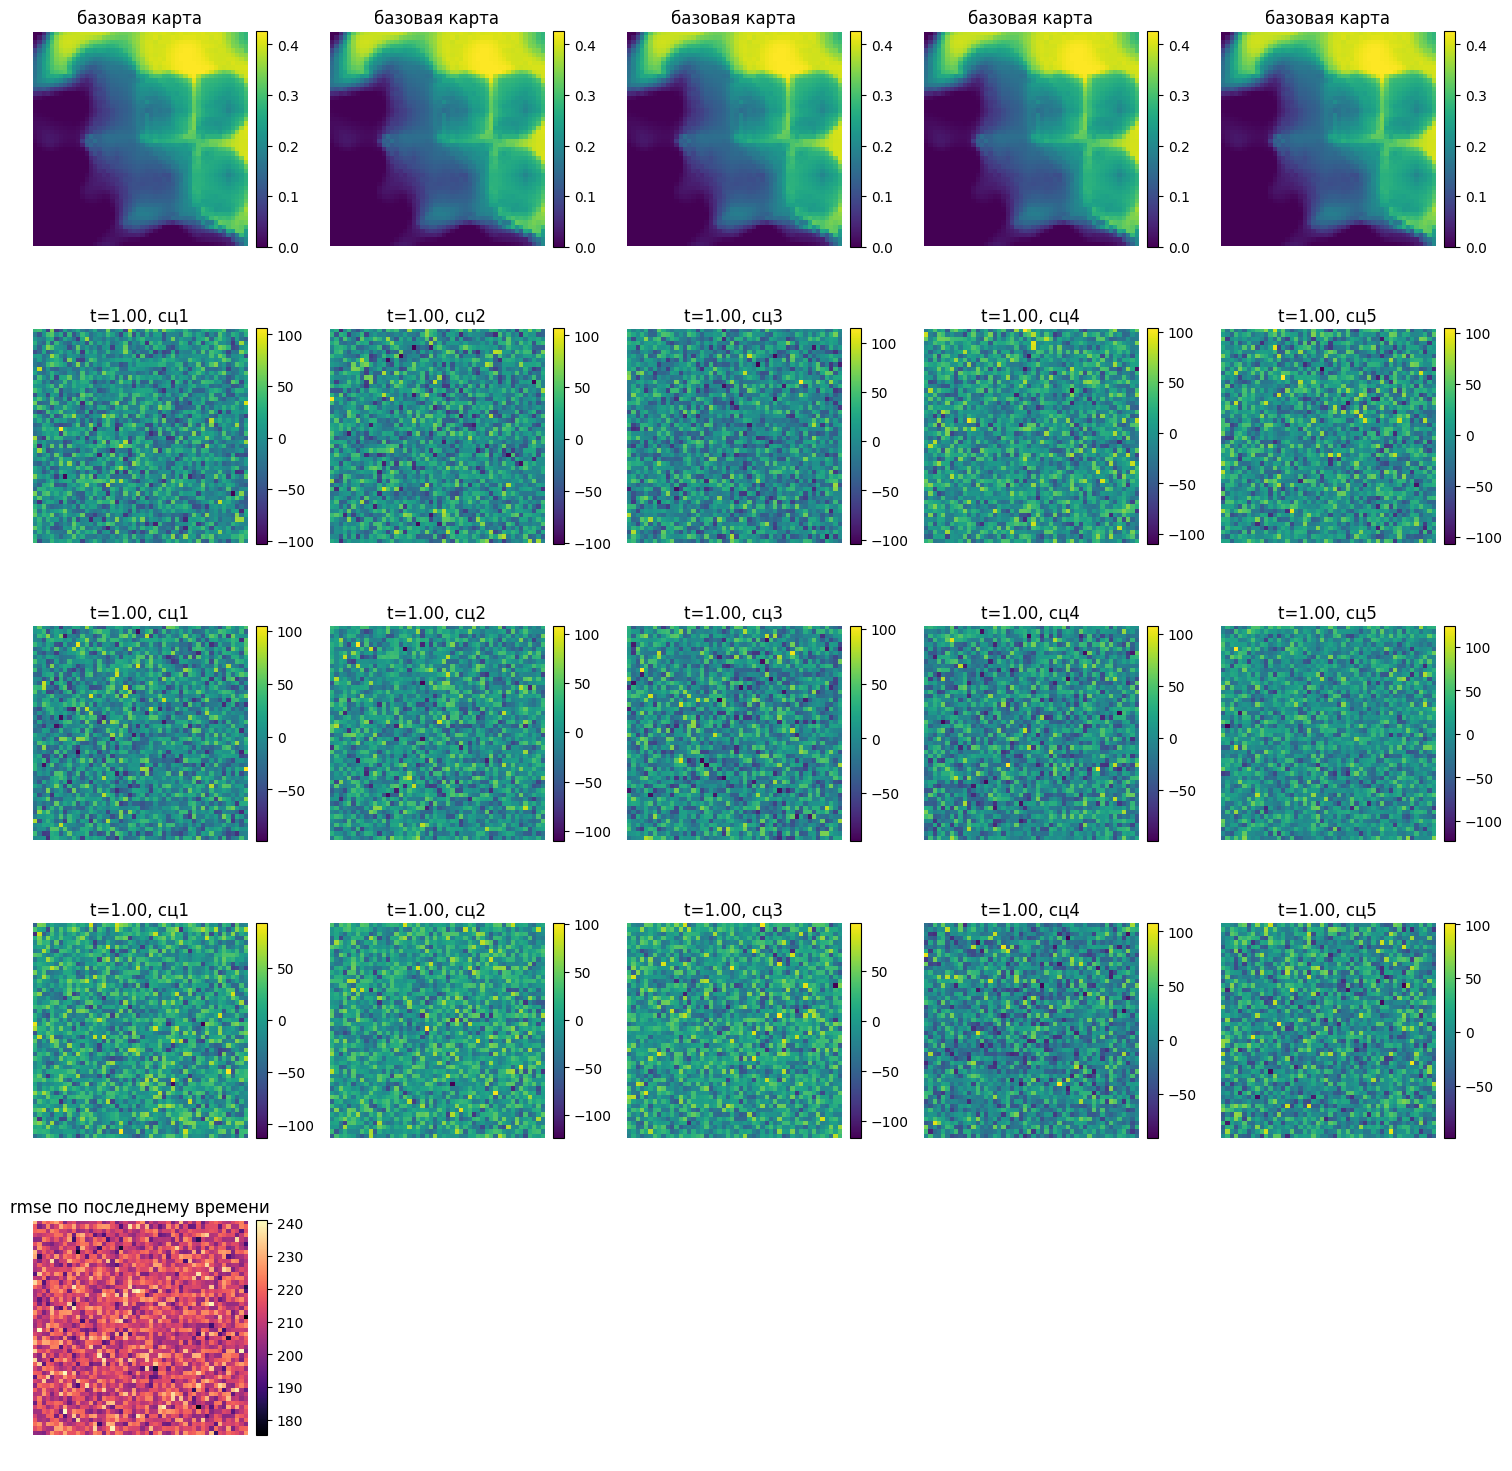

In [9]:
import matplotlib.pyplot as plt

if val_subset is not None and val_subset.indices:
    source_index = val_subset.indices[0]
else:
    source_index = 0
base_cond, base_target = nabor_dannykh[source_index]
static_channels = base_cond[:-1]
temporal_channel = base_cond[-1:]
base_time = float(temporal_channel.mean())
future_offsets = (0.1, 0.25, 0.45)
future_times = [min(1.0, base_time + offset) for offset in future_offsets]
samples_per_future = 5
scenario_rows = []
diffusion.eval()
with torch.no_grad():
    reference_target = base_target.unsqueeze(0).to(ustrojstvo)
    for future_time in future_times:
        cond_future = torch.cat(
            [static_channels, torch.full_like(temporal_channel, future_time)],
            dim=0,
        ).unsqueeze(0).to(ustrojstvo)
        batch_predictions = torch.stack(
            [diffusion.sample(cond_future) for _ in range(samples_per_future)]
        )
        rmse_values = torch.sqrt(
            ((batch_predictions - reference_target) ** 2).mean(dim=(1, 2, 3))
        )
        rmse_values_list = [float(val) for val in rmse_values.detach().cpu().reshape(-1)]
        print(
            f"время {future_time:.2f}, rmse для каждого сценария: {', '.join(f'{val:.4f}' for val in rmse_values_list)}"
        )
        row_maps = []
        for sample_idx in range(samples_per_future):
            scenario_map = batch_predictions[sample_idx]
            if scenario_map.ndim > 2:
                scenario_map = scenario_map.mean(dim=tuple(range(scenario_map.ndim - 2)))
            row_maps.append(scenario_map.cpu().numpy())
        rmse_map = torch.sqrt(((batch_predictions - reference_target) ** 2).mean(dim=0))
        if rmse_map.ndim > 2:
            rmse_map = rmse_map.mean(dim=tuple(range(rmse_map.ndim - 2)))
        scenario_rows.append((future_time, row_maps, rmse_map.cpu().numpy()))


base_map = base_target.mean(dim=0).cpu().numpy()
rows = 2 + len(scenario_rows)
cols = samples_per_future
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), squeeze=False)

for col in range(cols):
    axes[0, col].imshow(base_map, origin="lower", cmap="viridis")
    axes[0, col].set_title("базовая карта")
    axes[0, col].axis("off")
    plt.colorbar(axes[0, col].images[0], ax=axes[0, col], fraction=0.046, pad=0.04)

for row_idx, (future_time, row_maps, rmse_map) in enumerate(scenario_rows, start=1):
    for col in range(cols):
        axes[row_idx, col].imshow(row_maps[col], origin="lower", cmap="viridis")
        axes[row_idx, col].set_title(f"t={future_time:.2f}, сц{col+1}")
        axes[row_idx, col].axis("off")
        plt.colorbar(axes[row_idx, col].images[0], ax=axes[row_idx, col], fraction=0.046, pad=0.04)

if scenario_rows and cols > 0:
    rmse_row = axes[-1]
    for col in range(cols):
        if col == 0:
            rmse_row[col].imshow(scenario_rows[-1][2], origin="lower", cmap="magma")
            rmse_row[col].set_title("rmse по последнему времени")
            rmse_row[col].axis("off")
            plt.colorbar(rmse_row[col].images[0], ax=rmse_row[col], fraction=0.046, pad=0.04)
        else:
            rmse_row[col].axis("off")

plt.tight_layout()
